# Tutorial part 2

## Gensim

* [gensim: models.word2vec – Deep learning with word2vec](https://radimrehurek.com/gensim/models/word2vec.html)
* [한국어와 NLTK, Gensim의 만남 - PyCon Korea 2015](https://www.lucypark.kr/docs/2015-pyconkr/)

In [44]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd

train = pd.read_csv('data/labeledTrainData.tsv', header=0, delimiter='\t', quoting=3)
test = pd.read_csv('data/testData.tsv', header=0, delimiter='\t', quoting=3)
unlabeled_train = pd.read_csv('data/unlabeledTrainData.tsv', header=0, delimiter='\t', quoting=3)

print(train.shape)
print(test.shape)
print(unlabeled_train.shape)

print(train['review'].size)
print(test['review'].size)
print(unlabeled_train['review'].size)

(25000, 3)
(25000, 2)
(50000, 2)
25000
25000
50000


In [3]:
from bs4 import BeautifulSoup
import re
from nltk.corpus import stopwords

def review_to_wordlist(review, remove_stopwords=False):
    # 1. HTML 제거
    review_text = BeautifulSoup(review, "html.parser").get_text()
    # 2. 특수문자를 공백으로 바꿔줌
    review_text = re.sub('[^a-zA-Z]', ' ', review_text)
    # 3. 소문자로 변환 후 나눈다.
    words = review_text.lower().split()
    # 4. 불용어 제거
    if remove_stopwords:
        stops = set(stopwords.words('english'))
        words = [w for w in words if not w in stops]
    # 5. Return a list of words
    return(words)

In [4]:
# punkt tokenizer 를 다운로드 받아 사용한다.
import nltk.data

def review_to_sentences( review, remove_stopwords=False ):
    # punkt tokenizer를 로드한다.
    tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')
    # 1. nltk tokenizer를 사용해서 단어로 토큰화 하고 공백 등을 제거한다.
    raw_sentences = tokenizer.tokenize(review.strip())
    # 2. 각 문장을 순회한다.
    sentences = []
    for raw_sentence in raw_sentences:
        # 비어있다면 skip
        if len(raw_sentence) > 0:
            # 태그제거, 알파벳문자가 아닌 것은 공백으로 치환, 불용어제거
            sentences.append(review_to_wordlist(raw_sentence, remove_stopwords))
    return sentences

In [5]:
review = train['review'][0]
remove_stopwords=False
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')

raw_sentences = tokenizer.tokenize(review.strip())
# 2. 각 문장을 순회한다.
sentences = []
for raw_sentence in raw_sentences:
    # 비어있다면 skip
    if len(raw_sentence) > 0:
        sentences.append(review_to_wordlist(raw_sentence, remove_stopwords))

In [6]:
# sentences를 초기화 해준다.
sentences = []

# for review in train['review']:
#     sentences += review_to_sentences(review)
    
%time train["sentences"] = train["review"].apply(review_to_sentences)

CPU times: user 37 s, sys: 2.32 s, total: 39.3 s
Wall time: 39.4 s


In [7]:
for review in unlabeled_train['review']:
    sentences += review_to_sentences(review, tokenizer)

In [8]:
len(sentences)

528987

In [9]:
sentences[0]

['watching', 'time', 'chasers', 'obvious', 'made', 'bunch', 'friends']

### 모델을 학습시킨다.

In [10]:
import logging
logging.basicConfig(
    format='%(asctime)s : %(levelname)s : %(message)s', 
    level=logging.INFO)

In [11]:
# 파라메터값 지정
num_features = 300 # 문자 벡터 차원 수
min_word_count = 40 # 최소 문자 수
num_workers = 4 # 병렬 처리 스레드 수
context = 10 # 문자열 창 크기
downsampling = 1e-3 # 문자 빈도 수 Downsample

# 초기화 및 모델 학습
from gensim.models import word2vec

# 모델 학습
model = word2vec.Word2Vec(sentences, 
                          workers=num_workers, 
                          size=num_features, 
                          min_count=min_word_count,
                          window=context,
                          sample=downsampling)
model

2017-12-31 00:19:00,169 : INFO : 'pattern' package not found; tag filters are not available for English
2017-12-31 00:19:00,175 : INFO : collecting all words and their counts
2017-12-31 00:19:00,177 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2017-12-31 00:19:00,209 : INFO : PROGRESS: at sentence #10000, processed 115423 words, keeping 17233 word types
2017-12-31 00:19:00,245 : INFO : PROGRESS: at sentence #20000, processed 227635 words, keeping 24591 word types
2017-12-31 00:19:00,281 : INFO : PROGRESS: at sentence #30000, processed 341925 words, keeping 29834 word types
2017-12-31 00:19:00,317 : INFO : PROGRESS: at sentence #40000, processed 456188 words, keeping 34015 word types
2017-12-31 00:19:00,351 : INFO : PROGRESS: at sentence #50000, processed 568057 words, keeping 37586 word types
2017-12-31 00:19:00,387 : INFO : PROGRESS: at sentence #60000, processed 683038 words, keeping 40853 word types
2017-12-31 00:19:00,426 : INFO : PROGRESS: at sentence

2017-12-31 00:19:13,753 : INFO : PROGRESS: at 21.79% examples, 513724 words/s, in_qsize 8, out_qsize 0
2017-12-31 00:19:14,755 : INFO : PROGRESS: at 23.65% examples, 511819 words/s, in_qsize 7, out_qsize 0
2017-12-31 00:19:15,768 : INFO : PROGRESS: at 25.68% examples, 513116 words/s, in_qsize 7, out_qsize 0
2017-12-31 00:19:16,801 : INFO : PROGRESS: at 27.20% examples, 504216 words/s, in_qsize 7, out_qsize 0
2017-12-31 00:19:17,860 : INFO : PROGRESS: at 28.99% examples, 500259 words/s, in_qsize 7, out_qsize 0
2017-12-31 00:19:18,864 : INFO : PROGRESS: at 30.35% examples, 491519 words/s, in_qsize 7, out_qsize 0
2017-12-31 00:19:19,864 : INFO : PROGRESS: at 32.35% examples, 493545 words/s, in_qsize 7, out_qsize 0
2017-12-31 00:19:20,873 : INFO : PROGRESS: at 34.59% examples, 498465 words/s, in_qsize 7, out_qsize 0
2017-12-31 00:19:21,899 : INFO : PROGRESS: at 36.76% examples, 501549 words/s, in_qsize 8, out_qsize 0
2017-12-31 00:19:22,907 : INFO : PROGRESS: at 38.81% examples, 503047 wor

In [ ]:
model.init_sims(replace=True)

model_name = '300features_40minwords_10text'
model.save(model_name)

## 모델 결과 탐색 
Exploring the Model Results

In [12]:
model.wv.doesnt_match('man woman child kitchen'.split())

'kitchen'

In [13]:
model.wv.doesnt_match("france england germany berlin".split())

'berlin'

In [14]:
model.wv.most_similar("man")

[('lady', 0.6074769496917725),
 ('woman', 0.5855768322944641),
 ('men', 0.5360821485519409),
 ('lad', 0.4794219136238098),
 ('person', 0.4438636898994446),
 ('grandson', 0.4249945878982544),
 ('loretta', 0.4230838418006897),
 ('chap', 0.4191495180130005),
 ('hides', 0.4181428849697113),
 ('reggie', 0.4123213291168213)]

In [15]:
model.wv.most_similar("queen")

[('princess', 0.682346522808075),
 ('nina', 0.6509675979614258),
 ('mama', 0.6286352276802063),
 ('lillian', 0.6241617798805237),
 ('sylvia', 0.6225221157073975),
 ('bride', 0.6221849918365479),
 ('gypsy', 0.6212487816810608),
 ('eva', 0.6183563470840454),
 ('wu', 0.6099145412445068),
 ('virginal', 0.6068682074546814)]

In [16]:
model.wv.most_similar("awful")

[('terrible', 0.8147755861282349),
 ('horrible', 0.7624049186706543),
 ('dreadful', 0.743477463722229),
 ('atrocious', 0.7381424903869629),
 ('horrid', 0.733971118927002),
 ('abysmal', 0.7049808502197266),
 ('horrendous', 0.6861432790756226),
 ('lousy', 0.675512433052063),
 ('crappy', 0.6686009168624878),
 ('laughable', 0.6518042683601379)]

In [17]:
model.wv.most_similar("movie")

[('film', 0.6984893083572388),
 ('movies', 0.6210460066795349),
 ('flick', 0.6042723655700684),
 ('thats', 0.4238490164279938),
 ('guess', 0.40896308422088623),
 ('sequel', 0.4077339172363281),
 ('stuff', 0.40035539865493774),
 ('think', 0.3998739719390869),
 ('realized', 0.3917020261287689),
 ('thing', 0.38402700424194336)]

In [18]:
model.wv.most_similar("happy")

[('cry', 0.5074563026428223),
 ('sad', 0.4902622401714325),
 ('happier', 0.48968204855918884),
 ('gilmore', 0.48965954780578613),
 ('optimistic', 0.4654536843299866),
 ('happiness', 0.4590650796890259),
 ('sweet', 0.44053149223327637),
 ('hopeful', 0.44025543332099915),
 ('satisfied', 0.4303104281425476),
 ('cheat', 0.4280468225479126)]

In [54]:
# 참고 https://stackoverflow.com/questions/43776572/visualise-word2vec-generated-from-gensim
from sklearn.manifold import TSNE
import matplotlib as mpl
import matplotlib.pyplot as plt
import gensim 
import gensim.models as g

# 그래프에서 마이너스 폰트 깨지는 문제에 대한 대처
mpl.rcParams['axes.unicode_minus'] = False

model_name = '300features_40minwords_10text'
model = g.Doc2Vec.load(model_name)

vocab = list(model.wv.vocab)
X = model[vocab]

print(len(X))
# print(X[0])
tsne = TSNE(n_components=2)
# X_tsne = tsne.fit_transform(X[:1000,:])
X_tsne = tsne.fit_transform(X)

2017-12-31 00:52:20,084 : INFO : loading Doc2Vec object from 300features_40minwords_10text
2017-12-31 00:52:20,373 : INFO : loading wv recursively from 300features_40minwords_10text.wv.* with mmap=None
2017-12-31 00:52:20,374 : INFO : setting ignored attribute syn0norm to None
2017-12-31 00:52:20,375 : INFO : setting ignored attribute cum_table to None
2017-12-31 00:52:20,376 : INFO : loaded 300features_40minwords_10text


12907


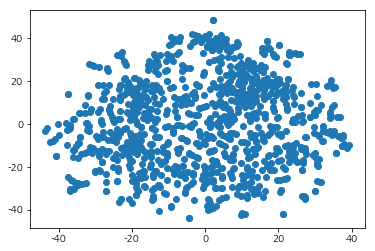

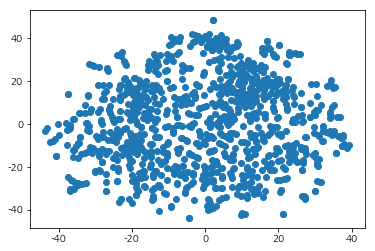

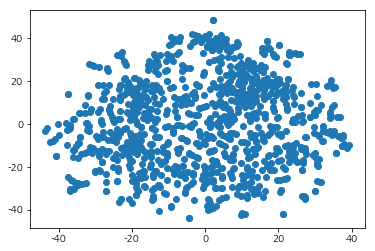

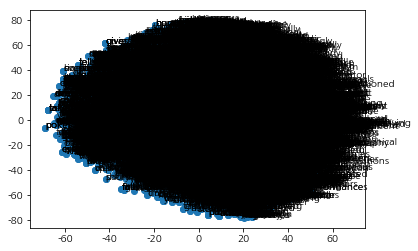

In [55]:
df = pd.DataFrame(X_tsne, index=vocab, columns=['x', 'y'])

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

ax.scatter(df['x'], df['y'])

for word, pos in df.iterrows():
    ax.annotate(word, pos)
plt.show()